# Introduction: Machine Learning Project Part 2

In this series of notebooks, we are working on a supervised, regression machine learning problem. Using real-world New York City building energy data, we want to predict the Energy Star Score and determine the factors that influence the score.

We are working through the outline of a machine learning project:

1. Data cleaning and structuring
2. Exploratory Data Analysis
3. Feature Engineering/Selection
4. Evaluate/compare several machine learning models on a performance metric
5. Perform hyperparameter tuning on the best model
6. Evaluate the best model on the testing set
7. Interpret the model results
8. Draw conclusions and write a well-documented report

The first notebook covered steps 1-3, and in this notebook, we will cover 4-6. I skip over all of the details of the machine learning models used here to focus on the implementation, but I would suggest reading this excellent book to get an idea of how they work and how to use them effectively in Python.


### Imports 

We will use most of the same imports as for the first part with the addition of some machine learning models. 

In [19]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

from IPython.core.pylabtools import figsize

import seaborn as sns

sns.set(font_scale = 2)

pd.set_option('display.max_columns', 60)

# Imputing missing values
from sklearn.preprocessing import Imputer, MinMaxScaler

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import itertools

### Read in Data

Here we will read in the formatted data that we cleaned in the previous notebook. 

In [2]:
# Read in data into dataframes from GitHub url
X = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/machine-learning-project/master/data/training_features.csv', header = 0)
X_test = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/machine-learning-project/master/data/testing_features.csv', header = 0)
y = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/machine-learning-project/master/data/training_labels.csv', header = 0)
y_test = pd.read_csv('https://raw.githubusercontent.com/WillKoehrsen/machine-learning-project/master/data/testing_labels.csv', header = 0)

# Display sizes of data
print('Training Feature Size: ', X.shape)
print('Testing Feature Size:  ', X_test.shape)
print('Training Labels Size:  ', y.shape)
print('Testing Labels Size:   ', y_test.shape)

Training Feature Size:  (6749, 77)
Testing Feature Size:   (2893, 77)
Training Labels Size:   (6749, 1)
Testing Labels Size:    (2893, 1)


As a reminder, here is what the formatted data looks like. In the first notebook, we engineered a number features by taking the natural log of the variables and we selected features by removing highly collinear features. Mostly we are focusing on numerical features, but we also included two categorical features that we saw are related to the Energy Star Score. These categorical variables have been one-hot encoded.

In [3]:
# Save features for later interpretation
features = X.columns

X.head(12)

,Order,Property Id,DOF Gross Floor Area,Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Indirect GHG Emissions (Metric Tons CO2e),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Latitude,Longitude,Community Board,Census Tract,log_Site EUI (kBtu/ft²),log_Weather Normalized Site EUI (kBtu/ft²),log_Weather Normalized Site Electricity Intensity (kWh/ft²),log_Direct GHG Emissions (Metric Tons CO2e),log_Water Use (All Water Sources) (kgal),log_Water Intensity (All Water Sources) (gal/ft²),Borough_Staten Island,Largest Property Use Type_Adult Education,Largest Property Use Type_Ambulatory Surgical Center,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_Bank Branch,Largest Property Use Type_College/University,...,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Public Services,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Other - Technology/Science,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Pre-school/Daycare,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility
0,4212,4932827,111567.0,98016.0,1913,1,100,63.8,12.1,2217126.8,23407.5,402.3,1924.7,18.37,40.769624,-73.968230,8.0,122.0,4.135167,4.155753,2.493205,4.768988,7.562525,2.910719,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6167,4406956,54030.0,63250.0,1930,1,100,NaN,NaN,4716513.9,NaN,11.0,5184.6,81.97,40.847999,-73.940296,12.0,265.0,4.335983,NaN,NaN,5.523459,8.553448,4.406353,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10770,4370684,149450.0,149450.0,1934,1,100,56.4,2.8,5988399.9,63472.7,136.9,NaN,NaN,40.645638,-73.981046,12.0,498.0,3.974058,4.032469,1.029619,5.869014,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6960,4401878,148827.0,159146.0,1982,1,100,74.2,4.8,8491331.1,92259.8,245.0,NaN,NaN,40.821001,-73.895580,2.0,159.0,4.247066,4.306764,1.568616,6.111467,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4928,2682511,377823.0,344857.0,1976,1,100,78.7,6.4,18623690.7,205135.3,747.4,NaN,NaN,40.773428,-73.953129,8.0,138.0,4.306764,4.365643,1.856298,6.896897,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,8272,3114850,72500.0,80475.0,1924,1,100,NaN,3.4,5252521.5,56063.4,90.9,NaN,NaN,40.835794,-73.852112,9.0,222.0,4.348987,NaN,1.223775,5.631212,NaN,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,11731,3114772,68076.0,75564.0,1940,1,100,NaN,2.2,4101299.9,43882.4,54.9,6365.2,84.24,40.629099,-73.957021,14.0,772.0,4.188138

# Evaluating and Comparing Machine Learning Models

## Imputing Missing Values

We can see there are missing values in a number of columns. Although we dropped features with more than 50% missing values, there are still quite a few left that must be addressed before we do machine learning. There are a number of methods for filling in missing values (known as imputation) but here we will use the relatively simple method of replacing missing values with the median of the column. In the code below, we create a scikit-learn `Imputer` object and then fill in the missing values.

Notice that we train the imputer (using the `.fit` method) on the training data but not the testing data. We then transform both the training data and testing data. This means that the missing values in the testing set are filled in with the median value of the corresponding columns in the training set. We have to do it this way rather than training on all the data because at production time, we will have to impute the missing values based on the previous training data and not on any new observations we get. 

In [4]:
# Make sure that all problem values are recorded as np.nan
X = X.replace({np.inf: np.nan, -np.inf: np.nan})
X_test = X_test.replace({np.inf: np.nan, -np.inf: np.nan})

In [5]:
# Create an imputer object with a median filling strategy
imputer = Imputer(strategy='median')

# Train on the training features
imputer.fit(X)

# Transform both training data and testing data
X = imputer.transform(X)
X_test = imputer.transform(X_test)

In [6]:
print('Missing values in training features: ', np.sum(np.isnan(X)))
print('Missing values in testing features:  ', np.sum(np.isnan(X_test)))

Missing values in training features:  0
Missing values in testing features:   0


In [7]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))
print(np.where(~np.isfinite(X_test)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


### Scaling Features

The final step to take before we can get to machine learning is to scale the features between 0 and 1. This is necessary because features are in different units, and we want to normalize the features so the units do not affect the algorithm. Linear Regression and Random Forest do not require feature scaling, but other methods, such as support vector machines and k nearest neighbors, do require it and so it is a best practice to scale all of the features before training a machine learning model. 

There are two ways to scale features:

1. Subtract the mean and divide by the standard deviation. This is often called standardization and results in each feature having a mean of 0 and a standard deviation of 1.
2. Subtract the minimum value from each feature value and divide by the maximum minus the minimum for the feature (the range of the feature). This assures that all the values for a feature are between 0 and 1.

As with imputation, when we train the scaling object, we want to use only the training set. When we transform features, we will transform both the training set and the testing set.

In [8]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

Just to remind ourselves, here is the naive baseline performance measured in mean absolute error.

In [9]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

baseline_guess = np.median(y)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

Baseline Performance on the test set: MAE = 25.3519


### Models to Evaluate

We will compare five different models:

1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression

To evaluate the models, we are going to be using the sklearn defaults for the model hyperparameters. Generally these will perform decent, but should be optimized before actually using a model. Now we just want to determine the baseline performance of each model, and then we can select the best-performer for further optimization. I don't want to get bogged down in the model theory or hyperparameters, so I'll leave it up to you to do some research. Just know that the default hyperparameters will get a model up and running, but nearly always should be adjusted using some sort of search to find the best settings for your problem.

One of the best parts about scikit-learn is that all models are implemented in basically the same manner: once you know how to build one, you can implement an extremely diverse array of models. Here we will implement the entire training and testing procedures for a number of models in just a few lines of code.

In [10]:
# Sklearn wants the labels as one-dimensional vectors
y = np.array(y).reshape((-1,))
y_test = np.array(y_test).reshape((-1,))

In [11]:
def fit_and_evaluate(model):
    model.fit(X, y)
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)
    
    return model_mae

In [12]:
# Create the model
lr = LinearRegression()
print('Linear Regression Performance on the test set: MAE = %0.4f' % fit_and_evaluate(lr))

Linear Regression Performance on the test set: MAE = 16.7341


In [13]:
svm = SVR(C = 1000, gamma = 0.1)
print('Support Vector Regression Performance on the test set: MAE = %0.4f' % fit_and_evaluate(svm))

Support Vector Regression Performance on the test set: MAE = 14.1151


In [14]:
random_forest = RandomForestRegressor()
print('Random Forest Regression Performance on the test set: MAE = %0.4f' % fit_and_evaluate(random_forest))

Random Forest Regression Performance on the test set: MAE = 9.8451


In [15]:
gradient_boosted = GradientBoostingRegressor()
print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % fit_and_evaluate(gradient_boosted))

Gradient Boosted Regression Performance on the test set: MAE = 10.0622


In [16]:
knn = KNeighborsRegressor(n_neighbors=10)
print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % fit_and_evaluate(knn))

K-Nearest Neighbors Regression Performance on the test set: MAE = 17.4093


The random forest does the best with the Gradient Boosted Regression coming in second. This is not the best comparison because we are using the default hyperparameters, and especially with the Support Vector Regressor, the hyperparameters have a significnant influence on performance. Nonetheless, we can conclude that machine learning is applicable because the random forest model significantly outperforms the baseline. 

# Optimizing the Best Model

Model __hyperparameters__ are best thought of as tunable settings for a machine learning algorithm that are set by the data scientist ahead to training time. An example would be the number of trees in the random forest, or the number of neighbors used in K Nearest Neighbors Regression. Model __parameters__ on the other hand are what the model learns during training, such as the weights in the linear regression or the exact structure of each decision tree. We as data scientists control the model by choosing the hyperparameters, and these choices can have a significant effect on the final performance of the model (although usually not as great of an effect as getting more data or engineering features). 

Generally, we adjust the model hyperparameters to control the amount of under or over fitting in our model. We can correct for under-fitting by making a more complex model, such as using more trees in a random forest or more layers in a deep neural network. A model that underfits has high bias, and occurs when our model does not have enough capacity or degrees of freedom to learn the relationship between the features and the target. We can try to correct for overfitting by limiting the complexity of the model and applying regularization. This might mean decreasing the degree of a polynomial regression, or adding dropout layers to a deep neural network. A model that overfits has high variance and in effect has memorized the training set. Both underfitting and overfitting lead to poor generalization performance on the test set. 

## Hyperparameter Tuning with Random Search and Cross Validation

We can choose the best hyperparameters for a model through random search and cross validation. Random search refers to the method in which we choose hyperparameters to evaluate: we define a range of options, and then randomly select combinations to try. This is in contrast to grid search which evaluates every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters and we can use random search to narrow down the options and then use grid search with a more limited range of options. Cross validation is the method used to assess the performance of the hyperparameters. Rather than splitting the training set up into separate training and validation sets which reduces the amount of training data we can use, we use K-Fold Cross Validation. This means dividing the training data into K folds, and then going through an iterative process where we first train on K-1 of the folds and then evaluate performance on the kth fold. We repeat this process K times so eventually we will have tested on every example in the training data with the key that each iteration we are testing on data that we __did not train on__.  At the end of K-fold cross validation, we take the average error on each of the K iterations as the final performance measure and then train the model on all the training data at once. The performance we record is then used to compare different combinations of hyperparameters. 

Here we will implement random search with cross validation to select the optimal hyperparameters for the random forest. We first define a grid and then iteratively randomly sample a set of hyperparameters from the grid, evaluate the hyperparameters using 4-fold cross-validation, and then select the hyperparameters with the best performance. 

In [21]:
# Number of trees in the forest
n_estimators = [100, 200, 300, 400, 500, 600, 700, 800]

# Maximum depth of each tree
max_depth = [None, 10, 20, 30, 40, 50, 60]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'max_features': max_features}

We selected 4 different hyperparameters to tune in the random forest. These all will affect the model in different ways that are hard to determine ahead of time, and the only method for finding the best combination for a specific problem is to test them out! To read about the hyperparameters, I suggest taking a look at the scikit-learn documentation for the random forest. For now, just know that we are trying to find the best combination of hyperparameters and because there is no theory to tell us which will work best, we just have to evaluate them, sort of like runnning an experiment.


In the code below, we create the Randomized Search Object passing in the following parameters:

* `estimator`: the model
* `param_distributions`: the distribution of parameters we defined
* `cv` the number of folds to use for k-fold cross validation
* `n_iter`: the number of different combinations to try
* `scoring`: which metric to use when evaluating candidates
* `n_jobs`: number of cores to run in parallel (-1 will use all available)
* `verbose`: how much information to display (1 displays a limited amount) 
* `return_train_score`: return the training score for each cross-validation fold
* `random_state`: fixes the random number generator used so we get the same results every run

The Randomized Search Object is trained the same way as any other scikit-learn model. After training, we can evaluate all the different hyperparameter combinations and find the best performing one. This can then be used to perform grid search, or we can just use these settings as the final ones. 

In [30]:
# Create the model to use for hyperparameter tuning
model = RandomForestRegressor(random_state = 42)

# Set up the random search with 4-fold cross validation
random_cv = RandomizedSearchCV(model, param_distributions=hyperparameter_grid,
                               cv=4, n_iter=25, scoring = 'neg_mean_absolute_error',
                               n_jobs = -1, verbose = 1, random_state=42)

In [31]:
# Fit on the training data
random_cv.fit(X, y)

Fitting 4 folds for each of 25 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished


RandomizedSearchCV(cv=4, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=-1,
          param_distributions={'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800], 'max_depth': [None, 10, 20, 30, 40, 50, 60], 'min_samples_leaf': [1, 2, 4, 6, 8], 'max_features': ['auto', 'sqrt', 'log2', None]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=1)

Scikit-learn uses the negative mean absolute error for evaluation because it wants a metric to maximize. Therefore, a better score will be closer to 0. We can get the results of the randomized search into a dataframe, and sort the values by performance.

In [32]:
# Get all of the cv results and sort by the test performance
random_results = pd.DataFrame(random_cv.cv_results_).sort_values('mean_test_score', ascending = False)

random_results.head(10)

C:\Users\willk\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\willk\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\willk\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\willk\Anaconda3\lib\site-packages\sklearn\utils\

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
2,50.182980,0.257937,-9.093136,-3.384145,60,auto,1,400,"{'n_estimators': 400, 'min_samples_leaf': 1, '...",1,-9.400874,-3.370514,-8.816949,-3.406770,-9.231566,-3.359313,-8.922971,-3.399985,0.142482,0.014793,0.234054,0.019782
19,27.007573,0.131099,-9.098269,-3.401847,40,None,1,200,"{'n_estimators': 200, 'min_samples_leaf': 1, '...",2,-9.420741,-3.388466,-8.817958,-3.418074,-9.236485,-3.374752,-8.917703,-3.426097,0.055266,0.010667,0.242021,0.021003
13,26.682472,0.148145,-9.098351,-3.402665,30,auto,1,200,"{'n_estimators': 200, 'min_samples_leaf': 1, '...",3,-9.420231,-3.388048,-8.814213,-3.418456,-9.243106,-3.376721,-8.915661,-3.427437,0.169498,0.005324,0.244283,0.020915
8,11.575539,0.057151,-9.108879,-3.931810,None,None,2,100,"{'n_estimators': 100, 'min_samples_leaf': 2, '...",4,-9.399846,-3.929285,-8.836594,-3.953931,-9.284826,-3.901245,-8.914079,-3.942780,0.085163,0.004963,0.238601,0.019687
6,50.604852,0.262448,-9.177524,-5.220312,40,auto,4,500,"{'n_estimators': 500, 'min_samples_leaf': 4, '...",5,-9.455321,-5.217603,-8.857832,-5.253102,-9.381737,-5.180702,-9.015041,-5.229840,0.275127,0.017213,0.248740,0.026183
15,51.609525,0.265708,-9.177524,-5.220312,30,None,4,500,"{'n_estimators': 500, 'min_samples_leaf': 4, '...",5,-9.455321,-5.217603,-8.857832,-5.253102,-9.381737,-5.180702,-9.015041,-5.229840,0.233738,0.009159,0.248740,0.026183
5,9.788284,0.041361,-9.203500,-5.242076,50,None,4,100,"{'n_estimators': 100, 'min_samples_leaf': 4, '...",7,-9.437459,-5.241582,-8.916676,-5.259685,-9.398743,-5.212892,-9.060983,-5.254145,0.049178,0.000434,0.221043,0.018081
9,8.755788,0.041863,-9.246512,-6.397655,10,None,4,100,"{'n_estimators': 100, 'min_samples_leaf': 4, '...",8,-9.501874,-6.404307,-8.966531,-6.443215,-9.427680,-6.327673,-9.089812,-6.415423,0.048297,0.010011,0.224157,0.042817
22,64.111023,0.234132,-9.296568,-6.212067,20,auto,6,800,"{'n_estimators': 800, 'min_samples_leaf': 6, '...",9,-9.584369,-6.208052,-8.935978,-6.260123,-9.489070,-6.169388,-9.176685,-6.210704,0.315609,0.001679,0.257047,0.032206
14,55.341449,0.247910,-9.297432,-6.215743,60,None,6,600,"{'n_estimators': 600, 'min_samples_leaf': 6, '...",10,-9.589846,-6.206113,-8.942439,-6.262485,-9.486806,-6.177121,-9.170464,-6.217253,0.224911,0.012185,0.256672,0.030706


It looks like the best model has the following hyperparameters:

* `n_estimators = 400`
* `min_samples_leaf = 1`
* `max_depth = 60`
* `max_features = auto` (This means that `max_features = n_features` according to the docs)

Now, we can further try to optimize by focusing on a narrower range of hyperparameters tat were seen to work best during the random search. We could do this by setting up a grid with hyperparameters very close to those that worked best during the randomized search. However, rather than evaluating all of these settings again, I will focus on a single one, the number of trees in the forest (`n_estimators`). By varying only one hyperparameter, we can directly observe how it affects performance. In the case of the number of trees, this should have significant impact on the amount of underfitting or overfitting. 

To determine the effect on the model of the number of trees, we can use grid search with a grid that only has the `n_estimators` hyperparameter. We can try out a range of trees and then plot the training and testing performance to get an idea of what increasing the number of trees does for our model. We will fix the other hyperparameters at the best values return from random search to isolate the number of trees effect.

In [37]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]}

model = RandomForestRegressor(min_samples_leaf = 1, max_depth = 60,
                              max_features = 'auto', random_state = 42,
                              n_jobs = -1)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(model, param_grid=trees_grid, cv = 4, 
                          scoring = 'neg_mean_absolute_error', verbose = 1, 
                          n_jobs = -1, return_train_score = True)

In [38]:
# Fit the grid search
grid_search.fit(X, y)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  4.4min finished


GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=1)

Text(0.5,1,'Performance vs Number of Trees')

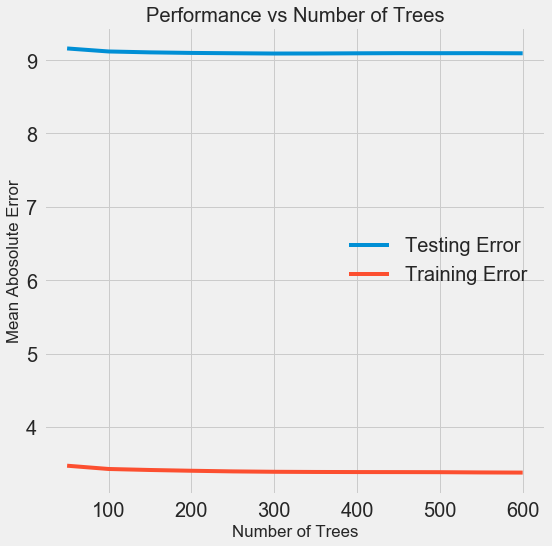

In [39]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
figsize(8, 8)
plt.style.use('fivethirtyeight')
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label = 'Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees'); plt.ylabel('Mean Abosolute Error'); plt.legend();
plt.title('Performance vs Number of Trees')

From these results, it's pretty clear our model is overfitting! The training error is significantly lower than the testing error, which shows that the model is memorizing the training data but then is not able to generalize well to the testing data. There are a number of ways we can try to correct this in a random forest, such as increasing the minimum number of samples at a leaf node.  but for now, we will use the best performing model on the test set and try to interpret the results. If you want, feel free to attempt to reduce the amount of overfitting so the model generalizes better to the testing set! 

Let's select the best model and implement it to make final predictions for the test set. 

# Evaluate Final Model on the Test Set

We will use the best model from the random search combined with the grid search to make predictions on the hold-out testing set. Remember, our model has never seen the test set before, so this metric should be a good indicator of how the model would perform if deployed in the real world. 

For comparison, we will again look at the performance of the default model. 

In [44]:
# Default model
default_model = RandomForestRegressor(random_state = 42, n_jobs = -1)

# Select the best model
final_model = grid_search.best_estimator_
final_model.n_jobs = -1

final_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=60,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [47]:
%%timeit -n 1 -r 5
default_model.fit(X, y)

335 ms ± 10.6 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [48]:
%%timeit -n 1 -r 5
final_model.fit(X, y)

5.99 s ± 973 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


The final model is quite a bit slower than the default (18 times slower on my machine). In a production setting, we would have to balance the increased run time against the difference in performance.

In [50]:
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 9.9946.
Final model performance on the test set:   MAE = 9.4806.


The final model does out-perform the baseline model by about 5%, but at the cost of significantly increased running time. Machine learning is often a field of tradeoffs: bias vs variance, acccuracy vs interpretability, accuracy vs running time, and the final decision depends on the use case. Here, I am find with the increase in run time because while the relative difference is large, the absolute magnitude of the training time is not significant. In a different situation, the balance might not be the same so we would need to consider what we are optimizing for and the limitations we have to work with. 

# Conclusions

In this notebook, we saw how to evaluate several machine learning methods using the default parameters in scikit-learn. We compared the results of the models and selected the one that performed the best for hyperparameter tuning. We then optimized the hyperparameters using random search with cross validation and then grid search with cross validation. Finally, we took the final model and evaluate the performance on the test set. 

Based on the results, we can say that our model is able to predict the Energy Star Score of a building to within +- 9.48 points. We also saw that tuning the hyperparameters of the random forest did improve performance slightly, although there was a tradeoff in terms of time to train the model. 

The next step in the machine learning process is my favorite: trying to understand why the model makes the predictions it does. Achieveing high accuracy is great, but it would also be helpful if we could figure out why the model is able to predict accurately. What features does it rely on to infer the Energy Star Score? It is possible to use this model for feature selection and implement a simpler model that is more interpretable? In the final notebook, we will try to answer these questions and draw conclusions from the project that we can then apply to more machine learning problems.